XGBoost harnessing gridsearch cv to determine the best yield prediction parameters. Actual Vs. Predicted yield and feature importance bar plot generated for further analysis of results.

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [62]:
dataset = pd.read_csv('escobal_518_clim.csv')
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

In [63]:
#Variance Inflation Factor (VIF) analysis to uncover non-linear collinearity 
X=dataset.drop(["Rice_yield", "SAVI_ripe", "EVI_ripe", "NDVI_ripe", "NDVI_repro", "SAVI_repro", "SAVI_veg", "NDVI_veg", "EVI_veg", "total_length", "Temp_range", "Max_temp", "hum", "Emer_to_har", "Min_temp", "Wet_day_freq", "Sun_light", "Total_precip_days"], axis=1)
vif = pd.DataFrame()
vif["features"] = X.columns
vif["vif_Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

         features  vif_Factor
0  Seedling_stage    6.542486
1    Drought_days    3.961486
2       EVI_repro   10.419636


In [64]:
# Split data 80% train, 20% test for model testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [65]:
model = xgb.XGBRegressor()
param_grid = {
    'n_estimators': [300, 400, 500, 600, 800, 1000],
    'colsample_bytree': [0.5, 1, 2, 4, 8, 10, 16],
    'max_depth': [1,3,5,10, 15],
    'reg_alpha': [0.5, 1, 2, 5, 10, 20, 25],
    'reg_lambda': [1, 5, 10, 15, 20],
    'subsample': [0.5, 1, 2]
}

model, pred = algorithm_pipeline(X_train, X_test, y_train, y_test, model, 
                                 param_grid, cv=2)

Fitting 2 folds for each of 22050 candidates, totalling 44100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 1098 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 2722 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done 4986 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 7906 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 11466 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 24522 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 43946 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 44100 out of 44100 | elapsed:  4.6min finished


[11:00:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [66]:
y_pred_grid = model.predict(X_test)
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
print(r2_score(y_test, y_pred_grid))
print(mean_absolute_error(y_test, y_pred_grid))
mean_squared_error(y_test, y_pred_grid)
print(np.sqrt(mean_squared_error(y_test, y_pred_grid)))
model.best_estimator_

0.9485511693764479
191.21169024999986
250.95868804601167


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=1, min_child_weight=1, missing=None, n_estimators=600,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0.5, reg_lambda=10, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.5, verbosity=1)

In [67]:
model.best_params_

{'colsample_bytree': 0.5,
 'max_depth': 1,
 'n_estimators': 600,
 'reg_alpha': 0.5,
 'reg_lambda': 10,
 'subsample': 0.5}

In [68]:
np.set_printoptions(precision=2)
print(np.concatenate((y_pred_grid.reshape(len(y_pred_grid), 1), y_test.reshape(len(y_test), 1)), 1))

[[ 7797.97  7640.67]
 [10325.28 10336.56]
 [ 8823.84  9228.89]]


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


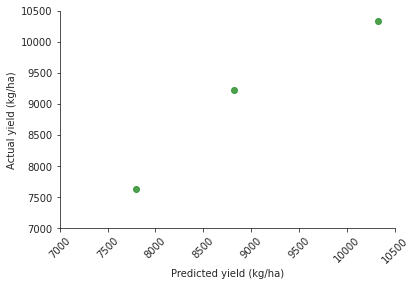

In [69]:
#Predicted vs actual yield scatter graph
import seaborn as sns
sns.set_style('ticks')
sns.regplot(y_pred_grid, y_test, data=dataset, color="forestgreen", fit_reg=False)
#np.concatenate((y_pred_grid.reshape(len(y_pred_grid), 1), y_test.reshape(len(y_test), 1)), 1)
plt.xlim(7000,10500)
plt.ylim(7000,10500)
plt.xticks(rotation=45)
plt.xlabel("Predicted yield (kg/ha)")
plt.ylabel("Actual yield (kg/ha)")
sns.despine()
plt.savefig('fed67_scatter.png')

[0.26 0.21 0.53]


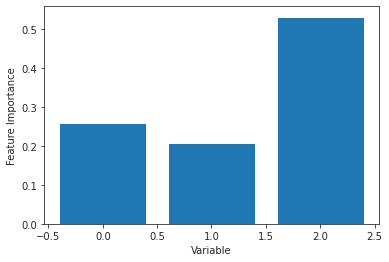

In [70]:
# Feature importance bar plot of variables influence on yield prediction
print(model.best_estimator_.feature_importances_)
# Plotting
plt.bar(range(len(model.best_estimator_.feature_importances_)), model.best_estimator_.feature_importances_)
model.best_estimator_. get_booster().get_score(importance_type="gain")
plt.xlabel("Variable")
plt.ylabel("Feature Importance")
plt.show()